In [2]:
import numpy as np
import random
import torch
import torch.nn as nn

def set_seed(seed: int = 1) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    print(f"Random seed set as {seed}")


class Qfunction(nn.Module):
    def __init__(self, state_dim, action_dim, nn_size):
        super().__init__()
        self.linear_1 = nn.Linear(state_dim, nn_size)
        self.linear_2 = nn.Linear(nn_size, int(nn_size / 2))
        self.linear_3 = nn.Linear(int(nn_size / 2), action_dim)
        self.activation = nn.ReLU()

    def forward(self, states):
        hidden = self.linear_1(states)
        hidden = self.activation(hidden)
        hidden = self.linear_2(hidden)
        hidden = self.activation(hidden)
        actions = self.linear_3(hidden)
        return actions

class DQN:
    def __init__(self, state_dim, action_dim, nn_size, gamma=0.99, lr=1e-3, batch_size=64, epsilon_decrease=0.01, epsilon_min=0.01):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.q_function = Qfunction(self.state_dim, self.action_dim, nn_size)
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = 1
        self.epsilon_decrease = epsilon_decrease
        self.epsilon_min = epsilon_min
        self.memory = []
        self.optimizer = torch.optim.Adam(self.q_function.parameters(), lr=lr)

    def get_action(self, state): # epsilon greedy action
        q_values = self.q_function(torch.FloatTensor(state))
        argmax_action = torch.argmax(q_values)
        probs = self.epsilon * np.ones(self.action_dim) / self.action_dim
        probs[argmax_action] += 1 - self.epsilon
        action = np.random.choice(np.arange(self.action_dim), p=probs)
        return action
    
    def fit(self, state, action, reward, done, next_state):
        self.memory.append([state, action, reward, int(done), next_state])

        if len(self.memory) > self.batch_size:
            batch = random.sample(self.memory, self.batch_size)
            states, actions, rewards, dones, next_states = map(torch.tensor, list(zip(*batch)))
    
            targets = rewards + self.gamma * (1 - dones) * torch.max(self.q_function(next_states), dim=1).values
            q_values = self.q_function(states)[torch.arange(self.batch_size), actions]
            
            loss = torch.mean((q_values - targets.detach()) ** 2)
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            
            if self.epsilon > self.epsilon_min:
                self.epsilon -= self.epsilon_decrease
                
                
    def learn_agent(self, env, episode_n, t_max):
        
        rewards = []
        
        for i in range(episode_n):
            total_reward = 0

            state = env.reset()
            for t in range(t_max):
                action = self.get_action(state)
                next_state, reward, done, _ = env.step(action)

                total_reward += reward
                
                self.fit(state, action, reward, done, next_state)

                state = next_state

                if done:
                    break
                
            rewards.append(total_reward)
            
            if i % 10 == 0:
                print(f'episode: {i}, total_reward: {total_reward}')
            
        return rewards
    
    
    
class DQNHard(DQN):
    def __init__(self, state_dim, action_dim, nn_size, update_iterations, gamma=0.99, lr=1e-3, batch_size=64, epsilon_decrease=0.01, epsilon_min=0.01):
        super().__init__(state_dim, action_dim, nn_size, gamma, lr, batch_size, epsilon_decrease, epsilon_min)

        self.q_to_update = Qfunction(self.state_dim, self.action_dim, nn_size)
        self.q_to_update.load_state_dict(self.q_function.state_dict())
        self.updates = update_iterations

    def fit(self, state, action, reward, done, next_state):
        
        steps = 0 
        
        self.memory.append([state, action, reward, int(done), next_state])

        if len(self.memory) > self.batch_size:
            steps += 1
            batch = random.sample(self.memory, self.batch_size)
            states, actions, rewards, dones, next_states = map(torch.tensor, list(zip(*batch)))

            targets = (rewards + self.gamma * (1 - dones) * torch.max(self.q_to_update(next_states), dim=1).values)
            q_values = self.q_function(states)[torch.arange(self.batch_size), actions]

            loss = torch.mean((q_values - targets.detach()) ** 2)
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()

            if self.epsilon > self.epsilon_min:
                self.epsilon -= self.epsilon_decrease

            if steps % self.updates == 0: self.q_to_update.load_state_dict(self.q_function.state_dict())
            
            
class DQNSoft(DQN):
    def __init__(self, state_dim, action_dim, nn_size, t, gamma=0.99, lr=1e-3, batch_size=64, epsilon_decrease=0.01, epsilon_min=0.01):
        super().__init__(state_dim, action_dim, nn_size, gamma, lr, batch_size, epsilon_decrease, epsilon_min)

        self.q_to_update = Qfunction(self.state_dim, self.action_dim, nn_size)
        self.q_to_update.load_state_dict(self.q_function.state_dict())
        self.t = t

    def fit(self, state, action, reward, done, next_state):
        self.memory.append([state, action, reward, int(done), next_state])

        if len(self.memory) > self.batch_size:
            batch = random.sample(self.memory, self.batch_size)
            states, actions, rewards, dones, next_states = map(torch.tensor, list(zip(*batch)))

            targets = (rewards + self.gamma * (1 - dones) * torch.max(self.q_to_update(next_states), dim=1).values)
            q_values = self.q_function(states)[torch.arange(self.batch_size), actions]

            loss = torch.mean((q_values - targets.detach()) ** 2)
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            
            for q_to_update_params, q_params in zip(self.q_to_update.parameters(), self.q_function.parameters()):
                q_to_update_params.data = (self.t * q_params.data + (1.0 - self.t) * q_to_update_params.data.detach())

            if self.epsilon > self.epsilon_min:
                self.epsilon -= self.epsilon_decrease
                

class DDQN(DQN):
    def __init__(self, state_dim, action_dim, nn_size, t, gamma=0.99, lr=1e-3, batch_size=64, epsilon_decrease=0.01, epsilon_min=0.01):
        super().__init__(state_dim, action_dim, nn_size, gamma, lr, batch_size, epsilon_decrease, epsilon_min)

        self.q_to_update = Qfunction(self.state_dim, self.action_dim, nn_size)
        self.q_to_update.load_state_dict(self.q_function.state_dict())
        self.t = t

    def fit(self, state, action, reward, done, next_state):
        self.memory.append([state, action, reward, int(done), next_state])

        if len(self.memory) > self.batch_size:
            batch = random.sample(self.memory, self.batch_size)
            states, actions, rewards, dones, next_states = map(torch.tensor, list(zip(*batch)))

            q_max_actions = torch.argmax(self.q_function(next_states), dim=1)
            targets = rewards + self.gamma * (1 - dones) * self.q_to_update(next_states)[torch.arange(self.batch_size), q_max_actions]
            q_values = self.q_function(states)[torch.arange(self.batch_size), actions]

            loss = torch.mean((q_values - targets.detach()) ** 2)
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            
            for q_to_update_params, q_params in zip(self.q_to_update.parameters(), self.q_function.parameters()):
                q_to_update_params.data = (self.t * q_params.data + (1.0 - self.t) * q_to_update_params.data.detach())

            if self.epsilon > self.epsilon_min:
                self.epsilon -= self.epsilon_decrease


            
set_seed()

Random seed set as 1


In [3]:
import gym

env = gym.make('Acrobot-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

agent = DQN(state_dim, action_dim, nn_size = 128)
rewards = agent.learn_agent(env=env, episode_n=200, t_max=1000)


# Final parameters: {'episode_n': 200, 't_max': 1000, 'nn_size': 128, 'batch_size': 64}

C:\Users\User\AppData\Local\Temp\ipykernel_2508\1155804508.py:56: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  states, actions, rewards, dones, next_states = map(torch.tensor, list(zip(*batch)))


episode: 0, total_reward: -461.0
episode: 10, total_reward: -87.0
episode: 20, total_reward: -78.0
episode: 30, total_reward: -160.0
episode: 40, total_reward: -112.0
episode: 50, total_reward: -166.0
episode: 60, total_reward: -108.0
episode: 70, total_reward: -195.0
episode: 80, total_reward: -170.0
episode: 90, total_reward: -130.0
episode: 100, total_reward: -117.0
episode: 110, total_reward: -88.0
episode: 120, total_reward: -79.0
episode: 130, total_reward: -95.0
episode: 140, total_reward: -180.0
episode: 150, total_reward: -124.0
episode: 160, total_reward: -95.0
episode: 170, total_reward: -119.0
episode: 180, total_reward: -85.0
episode: 190, total_reward: -85.0


In [11]:
env = gym.make('Acrobot-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

agent = DQNHard(state_dim, action_dim, nn_size = 128, update_iterations = 20)
hard_rewards = agent.learn_agent(env=env, episode_n=200, t_max=1000)

episode: 0, total_reward: -245.0
episode: 10, total_reward: -182.0
episode: 20, total_reward: -132.0
episode: 30, total_reward: -136.0
episode: 40, total_reward: -500.0
episode: 50, total_reward: -166.0
episode: 60, total_reward: -266.0
episode: 70, total_reward: -150.0
episode: 80, total_reward: -384.0
episode: 90, total_reward: -500.0
episode: 100, total_reward: -185.0
episode: 110, total_reward: -265.0
episode: 120, total_reward: -96.0
episode: 130, total_reward: -210.0
episode: 140, total_reward: -174.0
episode: 150, total_reward: -203.0
episode: 160, total_reward: -114.0
episode: 170, total_reward: -160.0
episode: 180, total_reward: -169.0
episode: 190, total_reward: -113.0


In [9]:
env = gym.make('Acrobot-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

agent = DQNSoft(state_dim, action_dim, nn_size = 128, t = 0.025)
soft_rewards = agent.learn_agent(env=env, episode_n=200, t_max=1000)

episode: 0, total_reward: -500.0
episode: 10, total_reward: -106.0
episode: 20, total_reward: -89.0
episode: 30, total_reward: -148.0
episode: 40, total_reward: -68.0
episode: 50, total_reward: -73.0
episode: 60, total_reward: -74.0
episode: 70, total_reward: -89.0
episode: 80, total_reward: -77.0
episode: 90, total_reward: -101.0
episode: 100, total_reward: -73.0
episode: 110, total_reward: -88.0
episode: 120, total_reward: -73.0
episode: 130, total_reward: -102.0
episode: 140, total_reward: -86.0
episode: 150, total_reward: -88.0
episode: 160, total_reward: -96.0
episode: 170, total_reward: -106.0
episode: 180, total_reward: -81.0
episode: 190, total_reward: -98.0


In [10]:
env = gym.make('Acrobot-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

agent = DDQN(state_dim, action_dim, nn_size = 128, t = 0.025)
ddqn_rewards = agent.learn_agent(env=env, episode_n=200, t_max=1000)

episode: 0, total_reward: -500.0
episode: 10, total_reward: -196.0
episode: 20, total_reward: -91.0
episode: 30, total_reward: -95.0
episode: 40, total_reward: -93.0
episode: 50, total_reward: -87.0
episode: 60, total_reward: -97.0
episode: 70, total_reward: -75.0
episode: 80, total_reward: -77.0
episode: 90, total_reward: -98.0
episode: 100, total_reward: -107.0
episode: 110, total_reward: -102.0
episode: 120, total_reward: -74.0
episode: 130, total_reward: -84.0
episode: 140, total_reward: -80.0
episode: 150, total_reward: -122.0
episode: 160, total_reward: -62.0
episode: 170, total_reward: -71.0
episode: 180, total_reward: -73.0
episode: 190, total_reward: -160.0


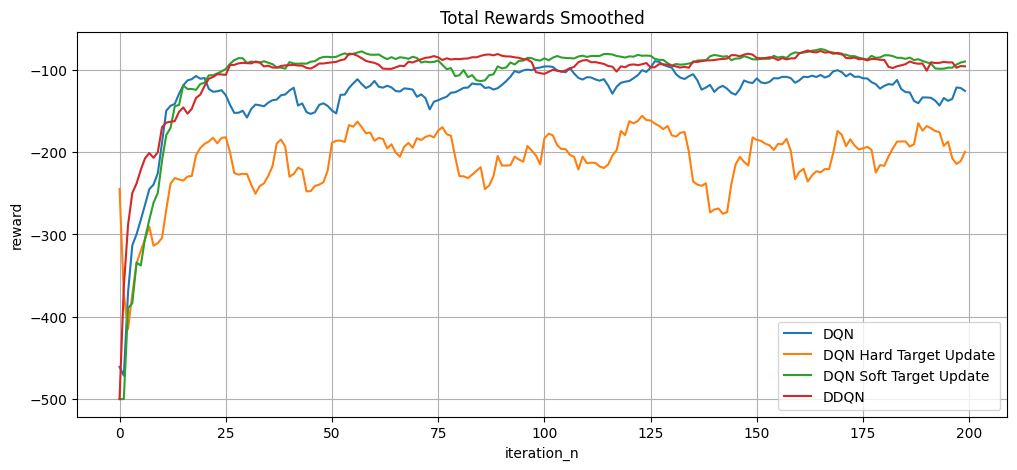

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['figure.figsize'] = (12, 5)
plt.plot(pd.Series(rewards).rolling(10, 1).mean(), label = 'DQN')
plt.plot(pd.Series(hard_rewards).rolling(10, 1).mean(), label = 'DQN Hard Target Update')
plt.plot(pd.Series(soft_rewards).rolling(10, 1).mean(), label = 'DQN Soft Target Update')
plt.plot(pd.Series(ddqn_rewards).rolling(10, 1).mean(), label = 'DDQN')
plt.xlabel("iteration_n")
plt.ylabel("reward")
plt.title('Total Rewards Smoothed')
plt.legend(loc = 'best')
plt.grid()
plt.show()

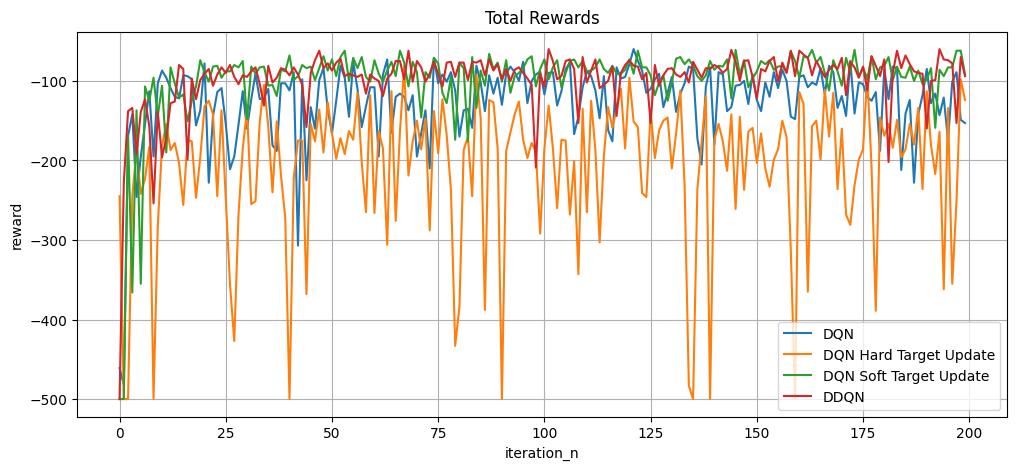

In [13]:
plt.plot(rewards, label = 'DQN')
plt.plot(hard_rewards, label = 'DQN Hard Target Update')
plt.plot(soft_rewards, label = 'DQN Soft Target Update')
plt.plot(ddqn_rewards, label = 'DDQN')
plt.xlabel("iteration_n")
plt.ylabel("reward")
plt.title('Total Rewards')
plt.legend(loc = 'best')
plt.grid()
plt.show()